In [52]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import VotingRegressor


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#!pip install scikit-optimize
#from skopt import BayesSearchCV

Defaulting to user installation because normal site-packages is not writeable


In [7]:
df = pd.read_csv('archive\insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
df_=pd.get_dummies(df, drop_first= True)
df_

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [29]:
X=df_.copy().drop('charges', axis=1)
y=df_['charges'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [65]:
dtr= DecisionTreeRegressor(max_depth=4)
dtr.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4)

In [64]:
display(type(dtr))

display(f'R2-score {dtr.score(X_test, y_test)}')


y_pred= dtr.predict(X_test)

display(f'Mean squared error {mean_squared_error(y_test, y_pred)}')



sklearn.tree._classes.DecisionTreeRegressor

'R2-score 0.8641310379678357'

'Mean squared error 21093484.004597437'

[Text(0.5, 0.875, 'x[4] <= 0.5\nsquared_error = 144333621.933\nsamples = 1070\nvalue = 13346.09'),
 Text(0.25, 0.625, 'x[0] <= 42.5\nsquared_error = 36246603.135\nsamples = 850\nvalue = 8578.323'),
 Text(0.125, 0.375, 'x[0] <= 22.5\nsquared_error = 22475509.0\nsamples = 467\nvalue = 5481.222'),
 Text(0.0625, 0.125, 'squared_error = 21689085.45\nsamples = 136\nvalue = 3364.762'),
 Text(0.1875, 0.125, 'squared_error = 20201941.331\nsamples = 331\nvalue = 6350.825'),
 Text(0.375, 0.375, 'x[0] <= 51.5\nsquared_error = 27081330.784\nsamples = 383\nvalue = 12354.682'),
 Text(0.3125, 0.125, 'squared_error = 23281896.272\nsamples = 160\nvalue = 10406.771'),
 Text(0.4375, 0.125, 'squared_error = 25131675.849\nsamples = 223\nvalue = 13752.287'),
 Text(0.75, 0.625, 'x[1] <= 29.972\nsquared_error = 134785661.424\nsamples = 220\nvalue = 31767.008'),
 Text(0.625, 0.375, 'x[0] <= 41.0\nsquared_error = 23902036.634\nsamples = 105\nvalue = 21006.654'),
 Text(0.5625, 0.125, 'squared_error = 10491005.759

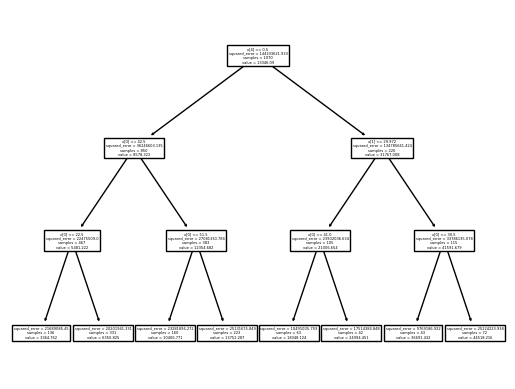

In [38]:
tree.plot_tree(dtr)

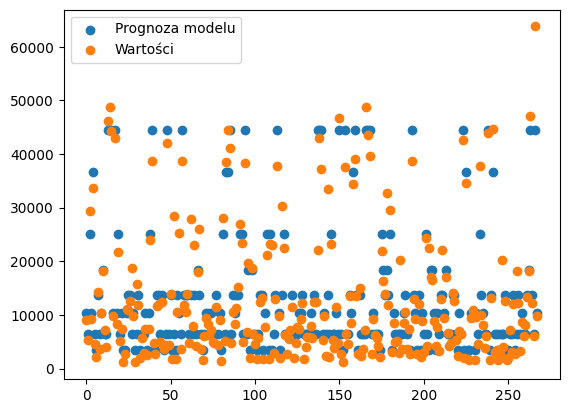

In [41]:


plt.scatter(range(len(y_pred)), y_pred, label = 'Prognoza modelu')
plt.scatter(range(len(y_pred)), y_test, label = 'Wartości')
plt.legend()